In [11]:
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import io
plt.rcParams["animation.ffmpeg_path"] = "C:\FFMPEG"

In [3]:
#Random Spin Configuration
def randominitial(N):
    rstate = 2*np.random.randint(2, size = (N, N)) - 1
    return rstate

#Fully Magnetized, all spins aligned
def fullinitial(N):
    fstate = np.ones((N, N), dtype = int)
    return fstate

#Monte Carlo move using Metropolis algorithm
def mcmc(config, beta):
    for i in range(N):
        for j in range(N):
            a = np.random.randint(0, N)
            b = np.random.randint(0, N)
            s = config[a, b]
            nb = config[(a + 1)%N, b] + config[a, (b + 1)%N] + config[(a - 1)%N, b] + config[a, (b - 1)%N]
            cost = 2*s*nb
            if cost < 0:
                s *= -1
            elif rand() < np.exp(-cost*beta):
                s *=-1
            config[a, b] = s
        return config
#Energy of a given configuration
def calcEnergy(config):
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i, j]
            k = config[(i + 1)%N, j] + config[i, (j + 1)%N] + config[(i - 1)%N, j] + config[i, (j - 1)%N]
            energy += -k*S
    return energy/4.

#Magnetization of a given configuration
def calcMag(config):
    mag = np.sum(config)
    return mag

N =  10     #N x N lattice
n_mc = 500  #mc steps run
nt = 500    #temperatures


tmax = .5
tmin = 5. 
T = np.linspace(.5,5.,nt)


#Empty array for random start values
Energy = np.zeros(nt);     Magnetization = np.zeros(nt)

Which configuration do you want to run?
 0: randomly mangetized 
 1: fully magnetized 
1
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
[[ 1  1  1 -1 -1  1  1 -1 -1  1]
 [-1  1 -1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1  1  1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1  1 -1 -1  1 -1 -1  1]
 [-1 -1  1  1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1 -1 -1  1 -1  1  1]
 [ 1 -1  1  1  1 -1 -1 -1 -1 -1]
 [-1  1  1  1  1 -1  1 -1  1 -1]
 [-1  1 -1 -1  1 -1  1 -1  1  1]
 [-1  1 -1  1 -1 -1 -1 -1 -1 -1]]


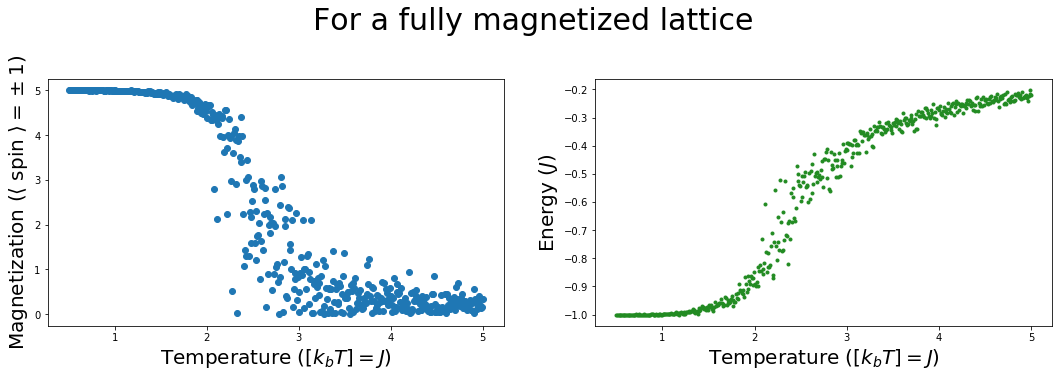

In [27]:
initial_state = float(input("Which configuration do you want to run?\n 0: randomly mangetized \n 1: fully magnetized \n"))

if initial_state == 0:
    config = randominitial(N)
    print(config) 
elif initial_state == 1:
    config = fullinitial(N)
    print(config)
    
for m in range(len(T)):
    E1 = M1 = E2 = M2 = 0
    iT = 1.0/T[m]; iT2 = iT*iT
       
    for i in range(n_mc):     #equilibrate
        mcmc(config, iT)       #Monte Carlo moves
        
    for i in range(n_mc):
        mcmc(config, iT)
        Nrg = calcEnergy(config)  #calculate energy
        Mag = calcMag(config)     #calculate the magnetization
        
        E1 = E1 + Nrg
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Nrg*Nrg
        
        n1 = 1.0/(n_mc*N*N)
        Energy[m] = n1*E1
        Magnetization[m] = n1*M1

print(config)
#Graph
f = plt.figure(figsize = (18, 10))
sp = f.add_subplot(2, 2, 2)
plt.plot(T, Energy, '.', color = 'forestgreen')
plt.xlabel(r"Temperature $([k_bT] = J)$", fontsize = 20)
plt.ylabel(r"Energy $(J)$", fontsize = 20)
        
sp = f.add_subplot(2, 2, 1)
#plt.plot(T, abs(Magnetization), '.', color = 'steelblue', 
         #T, np.tanh(Magnetization), color = 'r')
plt.scatter(T, abs(Magnetization))
#plt.plot(T,np.tanh(-T))
#plt.setp('.', color = 'steelblue')
#plt.setp(lines, color = 'r')
plt.xlabel(r"Temperature $([k_bT] = J)$", fontsize = 20)
plt.ylabel(r"Magnetization ($\langle$ spin $\rangle = \pm 1$)", fontsize = 20)

if initial_state == 0:
    plt.suptitle("For a randomly magnetized lattice", fontsize = 30)
elif initial_state == 1:
    plt.suptitle("For a fully magnetized lattice", fontsize = 30)

In [12]:
class Ising:
    
    _steps = int(2e6)
    
    def __init__(self, temp, initial_state, size = (100, 100), show = False):
        self.T = temp
        self.sqr_size = size[0]
        self.initialize(initial_state)
        
    def initialize(self, initial_state):
        if initial_state == 0:
            system = randominitial(N)
            #system[system == 0] = -1
        elif initial_state == 1:
            system = fullinitial(N)
            #system[system == 0] = -1
        self.system = system
    
    #periodic boundary condition heck if a lattice site coordinate falls out of bounds. If it does,
    #apply periodic boundary condition 
    def periodic_bound(self, i):
        if i + 1 > self.size - 1:
            return 0
        elif i - 1 < 0:
            return self.size
        else:
            return i
    def _energy(self, x, y):
        #Calc energy of spin interaction at one lattice point (x,y) with four nearest neighbors
        return -2*self.system[x, y]*(
                    self.system[self.periodic_bound(x - 1), y] 
                    + self.system[self.periodic_bound(x + 1), y] 
                    + self.system[x, self.periodic_bound(y - 1)] 
                    + self.system[x, self.periodic_bound(y + 1)]
                    )
    @property #backward compatible
    def internal_energy(self):
        e = 0; E = 0; E_2 = 0

        for i in range(self.size):
            for j in range(self.size):   
                e = self._energy(i, j)
                E += e
                E_2 += e**2

        U = (1./self.size**2)*E
        U_2 = (1./self.size**2)*E_2 

        return U, U_2
    
    #Find the overall magnetization of the system
    @property
    def magnetization(self):
        return np.abs(np.sum(self.system)/self.size**2)
    
    #Run the simulation
    def simulate(self, video = True):
        FFMpegWriter = manimation.writers['FFMPEG']
        writer = FFMpegWriter(fps = 10)
    

        plt.ion()
        fig = plt.figure()

        with writer.saving(fig, "ising.mp4", 100):
            for step in range(self._steps):
                #pick random lattice point
                x, y = np.random.randint(0, self.size, 2)

                #calc energy of a flipped spin
                E = -1*self._energy(x, y)

                print(E)
                #conditions for whether or not spin will flip (preferred state)
                if E <= 0.:
                    self.system[x, y]*=-1
                elif np.exp(-E/self.T) > np.random.random():
                    self.system[x, y]*=-1

                if step % (self._steps//75) == 0: 
                    print("Step {:.2E} / {:.2E}".format(step, self._steps), end ='\t')
                    print("Percent completed {:.2f}%".format(100*step/self._steps), end ='\t')
                    print("Net Magnetization: {:.2f}".format(self.magnetization))
                    if video:
                        img = plt.imshow(self.system, interpolation = 'nearest')
                        writer.grab_frame()
                        img.remove()
                
            print("...done")

        plt.close('all')
        
lattice = Ising(temp = .5, initial_state = initial_state, size=(100, 100))
lattice.simulate()

RuntimeError: No MovieWriters available!

What is the external magnetic field value? 5.0


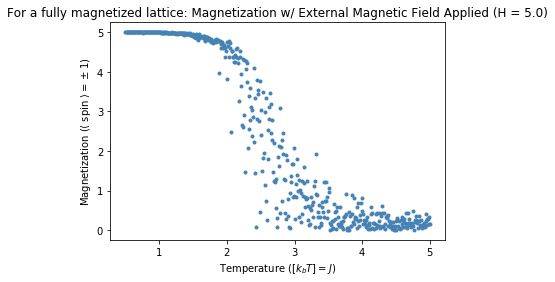

In [28]:
#External Magnetic Field
H = float(input("What is the external magnetic field value? "))
def calcMag(config):
    mag = np.sum(config)*H
    return mag
for m in range(len(T)):
    E1 = M1 = E2 = M2 = 0
    iT = 1.0/T[m]; iT2 = iT*iT
       
    for i in range(n_mc):     #equilibrate
        mcmc(config, iT)       #Monte Carlo moves
        
    for i in range(n_mc):
        mcmc(config, iT)
        Nrg = calcEnergy(config)  #calculate energy
        Mag = calcMag(config)     #calculate the magnetization
        
        E1 = E1 + Nrg
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Nrg*Nrg
        
        n1 = 1.0/(n_mc*N*N)
        Energy[m] = n1*E1
        Magnetization[m] = n1*M1
plt.plot(T, abs(Magnetization), '.', color = 'steelblue');
plt.xlabel(r"Temperature $([k_bT] = J)$")
plt.ylabel(r"Magnetization ($\langle$ spin $\rangle = \pm 1$)")
if initial_state == 0:
    plt.title("For a randomly magnetized lattice: Magnetization w/ External Magnetic Field Applied (H = %s)" %(H))
elif initial_state == 1:
    plt.title("For a fully magnetized lattice: Magnetization w/ External Magnetic Field Applied (H = %s)" %(H))

[[ 1  1 -1 -1  1  1 -1 -1 -1  1]
 [ 1  1 -1 -1  1  1  1  1  1  1]
 [ 1  1 -1 -1  1  1  1  1  1  1]
 [-1  1 -1  1  1  1  1 -1 -1 -1]
 [-1  1  1  1 -1  1  1 -1 -1  1]
 [ 1 -1  1 -1 -1 -1 -1 -1  1  1]
 [ 1  1 -1 -1 -1 -1 -1  1 -1 -1]
 [ 1 -1 -1 -1 -1 -1  1 -1 -1  1]
 [ 1  1 -1  1  1 -1  1  1  1 -1]
 [ 1  1  1  1  1  1  1  1 -1 -1]]


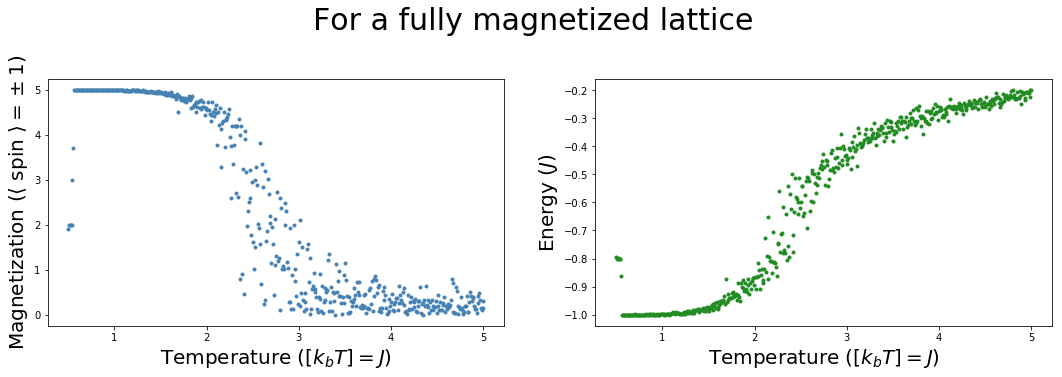

In [29]:
#Cool-Down Sequence
for m in range(len(T)):
    E1 = M1 = E2 = M2 = 0
    iT = 1.0/T[m]; iT2 = iT*iT
       
    for i in range(n_mc):     #equilibrate
        mcmc(config, iT)       #Monte Carlo moves
        
    for i in range(n_mc):
        mcmc(config, iT)
        Nrg = calcEnergy(config)  #calculate energy
        Mag = calcMag(config)     #calculate the magnetization
        
        E1 = E1 + Nrg
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Nrg*Nrg
        
        n1 = 1.0/(n_mc*N*N)
        Energy[m] = n1*E1
        Magnetization[m] = n1*M1

print(config)
#Graph
f = plt.figure(figsize = (18, 10))
sp = f.add_subplot(2, 2, 2)
plt.plot(T, Energy, '.', color = 'forestgreen')
plt.xlabel(r"Temperature $([k_bT] = J)$", fontsize = 20)
plt.ylabel(r"Energy $(J)$", fontsize = 20)
        
sp = f.add_subplot(2, 2, 1)
plt.plot(T, abs(Magnetization), '.', color = 'steelblue') 
         #T, np.tanh(Magnetization), color = 'r')
#plt.scatter(T, abs(Magnetization))
#plt.plot(T,np.tanh(-T))
#plt.setp('.', color = 'steelblue')
#plt.setp(lines, color = 'r')
plt.xlabel(r"Temperature $([k_bT] = J)$", fontsize = 20)
plt.ylabel(r"Magnetization ($\langle$ spin $\rangle = \pm 1$)", fontsize = 20)

if initial_state == 0:
    plt.suptitle("For a randomly magnetized lattice", fontsize = 30)
elif initial_state == 1:
    plt.suptitle("For a fully magnetized lattice", fontsize = 30)

What is the external magnetic field value? 5.0


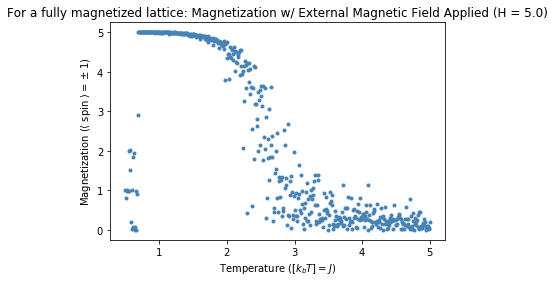

In [30]:
#External Magnetic Field w/ Cool Down Sequence
H = float(input("What is the external magnetic field value? "))
def calcMag(config):
    mag = np.sum(config)*H
    return mag
for m in range(len(T)):
    E1 = M1 = E2 = M2 = 0
    iT = 1.0/T[m]; iT2 = iT*iT
       
    for i in range(n_mc):     #equilibrate
        mcmc(config, iT)       #Monte Carlo moves
        
    for i in range(n_mc):
        mcmc(config, iT)
        Nrg = calcEnergy(config)  #calculate energy
        Mag = calcMag(config)     #calculate the magnetization
        
        E1 = E1 + Nrg
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Nrg*Nrg
        
        n1 = 1.0/(n_mc*N*N)
        Energy[m] = n1*E1
        Magnetization[m] = n1*M1
plt.plot(T, abs(Magnetization), '.', color = 'steelblue');
plt.xlabel(r"Temperature $([k_bT] = J)$")
plt.ylabel(r"Magnetization ($\langle$ spin $\rangle = \pm 1$)")
if initial_state == 0:
    plt.title("For a randomly magnetized lattice: Magnetization w/ External Magnetic Field Applied (H = %s)" %(H))
elif initial_state == 1:
    plt.title("For a fully magnetized lattice: Magnetization w/ External Magnetic Field Applied (H = %s)" %(H))